In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from pandasql import sqldf
import os
path = os.path.expanduser("~/Documents/m6A/Data")

### m6A peaks and nonpeaks

In [2]:
m6A_peaks = pd.read_table(f"{path}/metApeakFisher_jointpeaks_unmergebins_56lcls/unmerged_peaks_metApeak.bed", 
                          header = 0)
m6A_peaks = m6A_peaks.sort_values(by = ["# chr", "chromStart"])
m6A_peaks = m6A_peaks.rename(columns = {"# chr": "chr"})
m6A_peaks = m6A_peaks[m6A_peaks["score"] < 0.05]

In [3]:
m6A_nonpeaks = pd.read_table(f"{path}/metApeakFisher_jointpeaks_unmergebins_56lcls/unmerged_nonpeaks_metApeak.bed",
                             header = 0)
m6A_nonpeaks = m6A_nonpeaks.sort_values(by = ["score"], ascending = False)
m6A_nonpeaks = m6A_nonpeaks.rename(columns = {"# chr": "chr"})
m6A_nonpeaks = m6A_nonpeaks.iloc[:10000, :]

In [4]:
print (m6A_peaks.shape, m6A_nonpeaks.shape)

(96192, 12) (10000, 12)


In [5]:
peak_name = set(m6A_peaks["name"])
nonpeak_name = set(m6A_nonpeaks["name"])
uniq_peak_name = [name for name in peak_name if name not in nonpeak_name]
uniq_nonpeak_name = [name for name in nonpeak_name if name not in peak_name]
intersect_name = list(set(m6A_peaks["name"]) & set(m6A_nonpeaks["name"]))
union_name = list(set(m6A_peaks["name"]) | set(m6A_nonpeaks["name"]))

In [6]:
len(uniq_peak_name), len(uniq_nonpeak_name), len(intersect_name), len(union_name)

(4994, 1193, 3168, 9355)

### RBP binding sites

In [7]:
RBP_binding_sites = pd.read_table(f"{path}/all.RBP.intersect.hg19.bed", sep="\t", header = None, 
                                  names = ["chr", "start", "end", "name", "peak_width", "strand"])
RBP_binding_sites = RBP_binding_sites[RBP_binding_sites["peak_width"] <= 200]
RBP_name = set(RBP_binding_sites["name"])

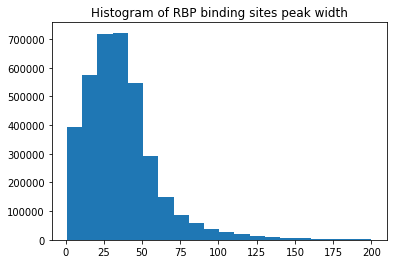

In [8]:
peak_width = RBP_binding_sites["peak_width"].tolist()
plt.hist(peak_width, bins = 20)  # arguments are passed to np.histogram
plt.title("Histogram of RBP binding sites peak width")
plt.show()

In [12]:
len(RBP_name)

121

In [11]:
len(RBP_name.intersection(peak_name))

97

In [13]:
len(RBP_name.intersection(nonpeak_name))

61

### Check whether RBP binding sites are more common in m6A sites

In [34]:
query = """
    SELECT peaks.chr, peaks.chromStart, peaks.chromEnd, peaks.name, peaks.score, rbp.chr, rbp.start, rbp.end, rbp.name, rbp.peak_width, rbp.strand
    FROM m6A_peaks peaks LEFT JOIN RBP_binding_sites rbp
    WHERE peaks.chr == "chrY" AND rbp.chr == "chrY"
    AND (
    (rbp.start >= peaks.chromStart AND rbp.start <= peaks.chromEnd)
    OR
    (rbp.end >= peaks.chromStart AND rbp.end <= peaks.chromEnd)
    OR
    (rbp.start <= peaks.chromStart AND rbp.end >= peaks.chromEnd)
    )
"""

In [35]:
peaks_Y = sqldf(query)

In [37]:
peaks_Y

,chr,chromStart,chromEnd,name,score,chr,start,end,name,peak_width,strand
0,chrY,21154050,21154100,CD24,0.032,chrY,21154007,21154055,KHDRBS1,49,-
1,chrY,21154050,21154100,CD24,0.032,chrY,21154080,21154081,LIN28B,2,-
2,chrY,21154050,21154100,CD24,0.032,chrY,21154081,21154126,ZNF622,46,-
3,chrY,21154050,21154100,CD24,0.032,chrY,21154083,21154196,SAFB2,114,-
4,chrY,21154100,21154150,CD24,0.020,chrY,21154081,21154126,ZNF622,46,-
5,chrY,21154100,21154150,CD24,0.020,chrY,21154083,21154196,SAFB2,114,-
6,chrY,21154100,21154150,CD24,0.020,chrY,21154126,21154185,HLTF,60,-
7,chrY,21154100,21154150,CD24,0.020,chrY,21154133,21154168,YBX3,36,-
8,chrY,21154100,21154150,CD24,0.020,chrY,21154140,21154174,ZNF622,35,-
9,chrY,21154100,21154150,CD24,0.020,chrY,21154143,21154181,UPF1,39,-


In [38]:
query_non_peaks = """
    SELECT nonpeaks.chr, nonpeaks.chromStart, nonpeaks.chromEnd, nonpeaks.name, nonpeaks.score, rbp.chr, rbp.start, rbp.end, rbp.name, rbp.peak_width, rbp.strand
    FROM m6A_nonpeaks nonpeaks LEFT JOIN RBP_binding_sites rbp
    WHERE nonpeaks.chr == "chrY" AND rbp.chr == "chrY"
    AND (
    (rbp.start >= nonpeaks.chromStart AND rbp.start <= nonpeaks.chromEnd)
    OR
    (rbp.end >= nonpeaks.chromStart AND rbp.end <= nonpeaks.chromEnd)
    OR
    (rbp.start <= nonpeaks.chromStart AND rbp.end >= nonpeaks.chromEnd)
    )
"""

In [39]:
non_peaks_Y = sqldf(query_non_peaks)

In [40]:
non_peaks_Y

,chr,chromStart,chromEnd,name,score,chr,start,end,name,peak_width,strand


In [44]:
len(set(m6A_peaks["name"]))

8162

In [45]:
len(set(m6A_nonpeaks["name"]))

4361

In [49]:
common_RBP = [name for name in set(m6A_peaks["name"]) if name in set(m6A_nonpeaks["name"])]

In [50]:
len(common_RBP)

3168